##  Prediction the sex of newborn

I have implemented Multi of Layer Perceptron(MLP) using Pytorch and XGBoost. For implemention by MLP, we go through these steps:

* Reduction dimension of dataset using Umap

* MLP (Model): Define the Layers , Activation function , Number of nodes for the MultiLayerPerceptron

* Structure of MLP : 2 Hidden Layers, Normalizing the batch data usign batchnorm in between each layer, Using ReLU Activation function between the layers, Using dropout before sending to output, Sigmoid at the output layer to make probabilities between 0 to 1.

Deep learning and tabular data infamously have a difficult relationship with each other. The homogeneity of data is not something that someone immediately thinks about when tackling tabular data. The exact characteristics that cause the weak performance of deep learning on tabular data are the following:

* 1-Different features in tables have different statistical properties. Some features correlate strongly with others and have a strong influence on what the outcome may be while others have minimal impact.

* 2-This correlation is also weaker than correlations prevalent in spatial or semantic relationships (image and audio).

In [5]:
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample # for Bootstrap sampling
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.linear_model import RidgeCV


In [3]:
with open("task1_multiomics_data.pickle", "rb") as file:
    data_multiomics = pickle.load(file)
    

cellfree_rna=data_multiomics["cellfree_rna"]
plasma_luminex=data_multiomics["plasma_luminex"]
serum_luminex=data_multiomics["serum_luminex"]
microbiome=data_multiomics["microbiome"]
immune_system=data_multiomics["immune_system"]
metabolomics=data_multiomics["metabolomics"]
plasma_somalogic=data_multiomics["plasma_somalogic"]
# Place the DataFrames side by side
data_frame = pd.concat([cellfree_rna, plasma_luminex, serum_luminex,microbiome, immune_system, metabolomics,plasma_somalogic], axis=1)
y = data_multiomics['sex_bin']

#### Reduction dimension of dataset 

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import umap # pip install umap-learn
import umap.umap_ as umap

# Preprocess on 
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(data_frame.copy())
manifold = umap.UMAP().fit(X, y)
X_reduced = manifold.transform(X)
X_reduced.shape

(68, 2)

#### Splitting dataset into Train & Test

In [5]:


train_x,test_x,train_y,test_y = train_test_split(X_reduced,y,random_state=42)
print("\n--Training data samples--")
print(train_x.shape)



--Training data samples--
(51, 2)


### Pytorch Neural Net Model
**Convert data into Pytorch Tensors**

In [9]:
###First use a MinMaxscaler to scale all the features of Train & Test dataframes

scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(train_x)
x_test =  scaler.fit_transform(test_x)


###Then convert the Train and Test sets into Tensors

x_tensor =  torch.from_numpy(x_train).float()
y_tensor =  torch.from_numpy(train_y.values.ravel()).float()
xtest_tensor =  torch.from_numpy(x_test).float()
ytest_tensor =  torch.from_numpy(test_y.values.ravel()).float()


#### DataLoader to pass the data in batches to the model

In [10]:
#Define a batch size , 
bs = 64
#Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
#Pytorch’s DataLoader is responsible for managing batches. 
#You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches
train_dl = DataLoader(train_ds, batch_size=bs)


#For the validation/test dataset
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

In [12]:
n_input_dim = train_x.shape[1]

#Layer size
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 100
n_output =  1   # Number of output nodes = for binary classifier


class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
    

model = ChurnModel()
print(model)

ChurnModel(
  (layer_1): Linear(in_features=2, out_features=300, bias=True)
  (layer_2): Linear(in_features=300, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


#### Defining parameters (pretty much standard setting for Binary class problem)
* Loss computation function : Here using Binary Cross Entropy (BCE) which is defacto for Binary class problems
* Learning rate : Setting as 0.001 (can be optimized further)
* Optimizer : Using Adam 
* Epochs of Training : setting as 50

In [14]:
#Loss Computation
loss_func = nn.BCELoss()
#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

### Training the MLP Model
NN Steps flow

* Forward Propagation
* Loss computation
* Backpropagation
* Updating the parameters

In [17]:
model.train()
train_loss = []
for epoch in range(epochs):
    #Within each epoch run the subsets of data = batch sizes.
    for xb, yb in train_dl:
        y_pred = model(xb)            # Forward Propagation
        loss = loss_func(y_pred, yb)  # Loss Computation
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 
    #print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
    train_loss.append(loss.item())
print('Last iteration loss value: '+str(loss.item()))

Last iteration loss value: 0.008822152391076088


**Plotting the loss shows that model pretty much stabilized after 30 epochs itself**

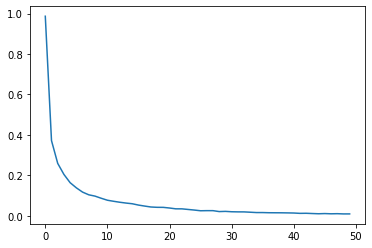

In [18]:
plt.plot(train_loss)
plt.show()

#### Test Dataset prediction on trained NN

In [19]:
import itertools

y_pred_list = []
model.eval()
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
    for xb_test,yb_test  in test_loader:
        y_test_pred = model(xb_test)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.detach().numpy())

#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

#### Metrics that matter

* Precision
* Recall
* F1 Score
* Confusion Matrix

In [20]:
y_true_test = test_y.values.ravel()
conf_matrix = confusion_matrix(y_true_test ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Precision of the MLP :\t"+str(precision_score(y_true_test,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(y_true_test,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(y_true_test,ytest_pred)))

Confusion Matrix of the Test Set
-----------
[[9 0]
 [0 8]]
Precision of the MLP :	1.0
Recall of the MLP    :	1.0
F1 Score of the Model :	1.0


### 3. XGBoostClassifier

### 3.2. Training

In [24]:



from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_clf.fit(train_x, train_y)

### 3.3 Evaluation 

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

print_score(xgb_clf, train_x, train_y, test_x, test_y, train=True)
#print_score(xgb_clf, train_x, train_y, test_x, test_y, train=False)


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision   1.0   1.0       1.0        1.0           1.0
recall      1.0   1.0       1.0        1.0           1.0
f1-score    1.0   1.0       1.0        1.0           1.0
support    27.0  24.0       1.0       51.0          51.0
_______________________________________________
Confusion Matrix: 
 [[27  0]
 [ 0 24]]

